Notebook to explore ESG correlations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
import importlib
import os, sys
import seaborn as sns
import tqdm

read data and order by sector

In [2]:
PRICE = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")
ESG_data = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
TICKERS = np.unique(ESG_data['ticker'])
companies = np.unique(PRICE['ticker']) 



esg_series = ESG_data.copy()  #ESG_data.loc[ESG_data['ticker'] == 'BMY'].copy()
esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
min_date = datetime.datetime(2014,10, 1)
max_date = np.max(ESG_data['timestamp'])
esg_series['date'] = esg_series['timestamp'].dt.date
print(min_date)
print(max_date)
esg_series


# Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
dates['date'] = dates['date'].dt.date

# create an esg data frame where index is monthly
esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
esg_pivot.set_index('date', inplace= True)
esg_pivot = esg_pivot.loc[:, esg_pivot.count() >10]  # remove observations with lass than 10 observations

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(esg_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
esg_pivot = esg_pivot.iloc[:, company_df['track_index']]


esg_pivot_enough_data = esg_pivot.loc[:,~np.isnan(esg_pivot.iloc[0,:])]
sector_classification = dict()
for company in esg_pivot.columns:
    sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
    if sector_of_company not in sector_classification.keys():
        sector_classification[sector_of_company] = list()
    sector_classification[sector_of_company].append(company)

esg_pivot



2014-10-01 00:00:00
2022-02-01 00:00:00


,ECL,MOS,APD,MLM,NEM,EMN,LYB,CF,CE,FCX,...,D,ETR,DTE,ES,DUK,CNP,ATO,ED,AEE,EIX
date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,64.00,70.00,73.00,47.00,72.00,65.00,57.00,44.00,57.00,61.0,...,64.00,65.00,66.00,68.00,60.00,60.00,54.00,66.00,60.00,61.00
2014-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot some ESG scores

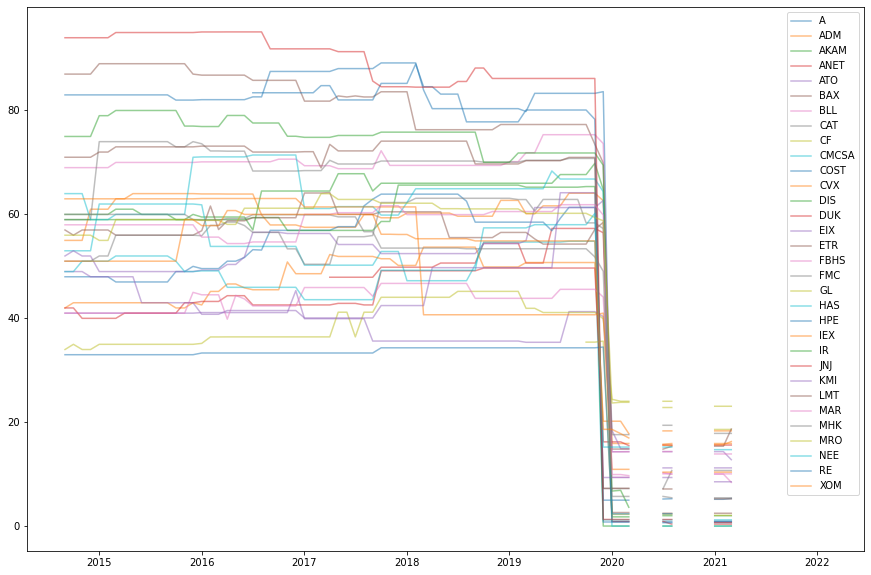

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in TICKERS[::10]:
    tmp = ESG_data.loc[ESG_data['ticker'] == ticker].sort_values(by = 'timestamp')
    out = plt.plot(tmp['timestamp'], tmp['environmentScore'], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

Here we offset all esg series by the shift. $y_{before} \gets y_{before} + a$ where $a$ is the negative shift that occurs. First Define function to find jump

In [4]:
def find_jump(y):
    """
    Returns
    -------------------------
    jump_index - index when jump occurs
    jump_index_prev - number of observation (nan not included) before jump
    biggest_jump_direction - size of the jump and direction (minus is jump down)


    
    """

    biggest_jump = 0
    biggest_jump_direction = 0
    prev_value = y[0,0]  # previous non nan value
    jump_index = 0
    jump_index_prev = 0

    observations = [0]
    for i in range(1,y.shape[0]):

        if np.isnan(y[i,0]):
            continue

        observations.append(i)


        this_jump = np.abs(y[i,0] - prev_value)
        this_jump_direction = y[i,0] - prev_value
        if this_jump > biggest_jump:
            biggest_jump = this_jump
            biggest_jump_direction = this_jump_direction
            jump_index_prev = observations[-2]
            jump_index = i

        prev_value = y[i,0]

    return jump_index, jump_index_prev, biggest_jump_direction

In [5]:

esg_pivot_shifted = esg_pivot.copy()

for stock in esg_pivot.columns:
    y_tmp = np.expand_dims(esg_pivot.loc[:,stock], axis = 1)  # the function assumes 2 dimensional array
    index, _, _ = find_jump(y_tmp)
    esg_pivot_shifted[stock].iloc[:index] = np.nanmean(esg_pivot[stock].iloc[index:]) - np.nanmean(esg_pivot[stock].iloc[:index]) + esg_pivot[stock].iloc[:index]




Plot after

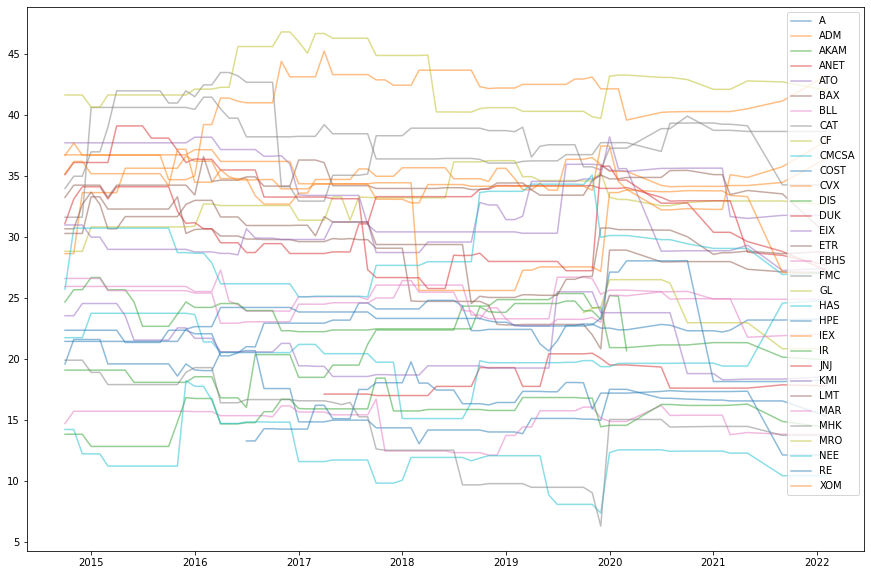

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
legend_ticks = []
for ticker in TICKERS[::10]:
    x = np.array(esg_pivot_shifted.index)
    y = np.array(esg_pivot_shifted[ticker])
    ymask = np.isfinite(y)
    out = ax.plot(x[ymask], y[ymask], alpha = 0.5)
    legend_ticks.append(ticker)

plt.legend(legend_ticks)

Looks ok, Still some spiky movements, which happens if there was a trend before the jump.

Next we look at correlations for the shifted series and shifted differenced series

# Pearson Correlation of non differced series

In [16]:
pearson_matrix = np.zeros((esg_pivot_shifted.shape[1], esg_pivot_shifted.shape[1]))

pbar = tqdm.tqdm(disable=False, total= (esg_pivot_shifted.shape[1]-1)*esg_pivot_shifted.shape[1]/2)
for i in range(esg_pivot_shifted.shape[1]):
    for j in range(i, esg_pivot_shifted.shape[1]):
        y1 = np.array(esg_pivot_shifted.iloc[:,i])
        y2 = np.array(esg_pivot_shifted.iloc[:,j])
        index = ~(np.isnan(y1) | np.isnan(y2))
        corr = np.corrcoef( y1[index], y2[index])[0,1]
        # Sometimes there are no co-occuring observations
        if ~np.any(index):
            pearson_matrix[i,j] = 0
        # It can happen that there are only ~3 co-occuring observations. and one/both series are constant in that time frame
        elif np.isnan(corr) :
            pearson_matrix[i,j] = 0
        else:
            pearson_matrix[i,j] = corr
        pbar.update()
pbar.close()
pearson_matrix = np.triu(pearson_matrix) + np.triu(pearson_matrix, 1).T


  7%|▋         | 3314/46360.0 [00:01<00:23, 1864.36it/s]C:\Users\ragna\Documents\Code\MMDGraph\.venv\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\ragna\Documents\Code\MMDGraph\.venv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\ragna\Documents\Code\MMDGraph\.venv\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ragna\Documents\Code\MMDGraph\.venv\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\ragna\Documents\Code\MMDGraph\.venv\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
 56%|█████▋    | 26083/46360.0 [00:12<00:10, 1972.57it/s]C:\Users\ragn

Look at raw heatmap, and a heatmap of data divided by

Text(0.5, 1.0, 'Pearson clipped')

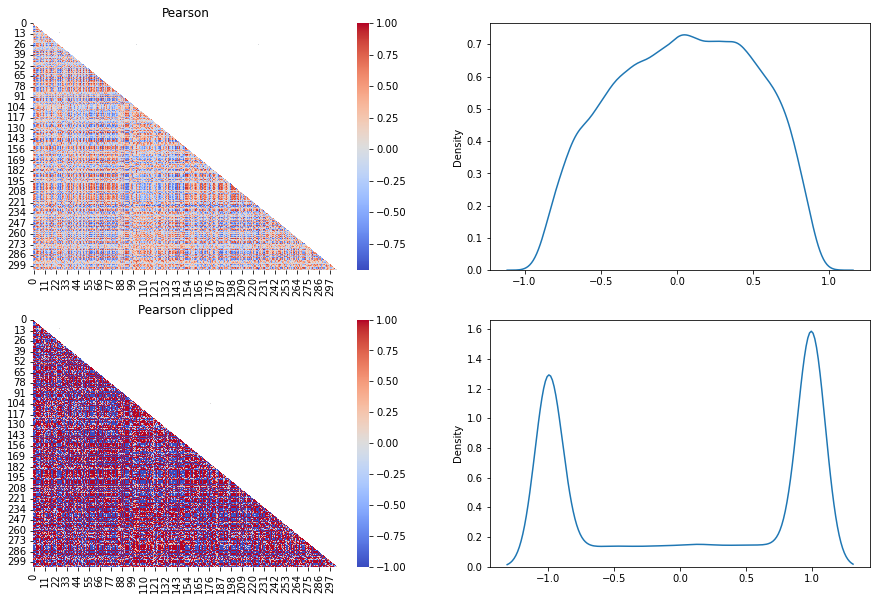

In [17]:
mat = pearson_matrix
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(mat, ax=ax[0,0], cmap="coolwarm",mask = np.triu(mat))
sns.kdeplot(mat[np.triu_indices(mat.shape[0], 1)], ax = ax[0,1])
ax[0,0].set_title('Pearson')

mat_clip = np.clip(mat/0.2,-1,1)
sns.heatmap(mat_clip, ax=ax[1,0], cmap="coolwarm",mask = np.triu(np.clip(mat_clip,-1,1)))
sns.kdeplot(mat_clip[np.triu_indices(mat_clip.shape[0], 1)], ax = ax[1,1])
ax[1,0].set_title('Pearson clipped')


Some pairs of observations have correlation almost 1. Let's look at those pairs

In [18]:
np.where(np.abs(np.triu(pearson_matrix,1))>0.98)

(array([113], dtype=int64), array([225], dtype=int64))

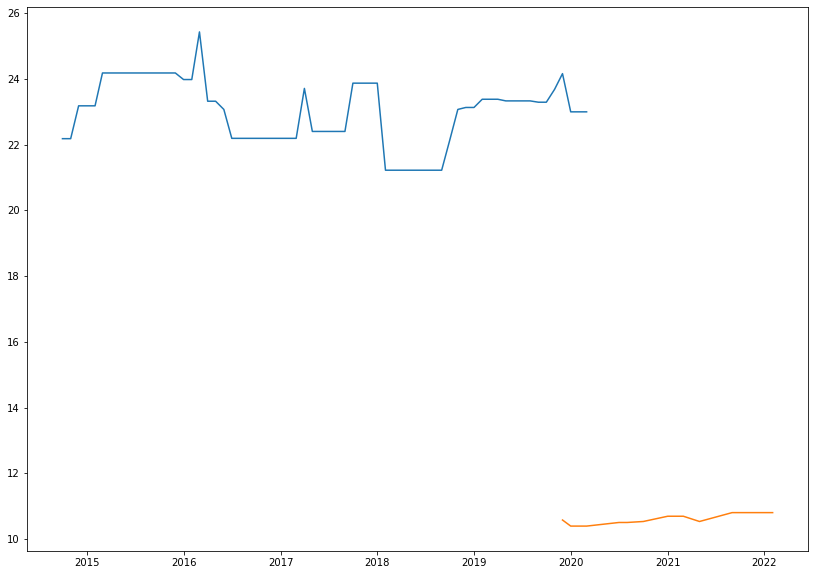

In [19]:
fig, ax = plt.subplots(figsize=(14,10))
x = np.array(esg_pivot_shifted.index)
y1 = np.array(esg_pivot_shifted.iloc[:, 113])
y2 = np.array(esg_pivot_shifted.iloc[:, 225])
ymask = np.isfinite(y)
ax.plot(x[ymask], y1[ymask])
ax.plot(x[ymask], y2[ymask])

So this happens when observations either start later og stop earlier. Let's do the same analysis where we observe more than 60 data points. We will use that data-set onwards

In [20]:
esg_pivot_refined = esg_pivot.loc[:, esg_pivot.count() >60] 
esg_pivot_shifted_refined = esg_pivot_refined.copy()

for stock in esg_pivot_refined.columns:
    y_tmp = np.expand_dims(esg_pivot_refined.loc[:,stock], axis = 1)  # the function assumes 2 dimensional array
    index, _, _ = find_jump(y_tmp)
    esg_pivot_shifted_refined[stock].iloc[:index] = np.nanmean(esg_pivot_refined[stock].iloc[index:]) - np.nanmean(esg_pivot_refined[stock].iloc[:index]) + esg_pivot_refined[stock].iloc[:index]




In [21]:
pearson_matrix_refined = np.zeros((esg_pivot_shifted_refined.shape[1], esg_pivot_shifted_refined.shape[1]))

pbar = tqdm.tqdm(disable=False, total= (esg_pivot_shifted_refined.shape[1]-1)*esg_pivot_shifted_refined.shape[1]/2)
for i in range(esg_pivot_shifted_refined.shape[1]):
    for j in range(i, esg_pivot_shifted_refined.shape[1]):
        y1 = np.array(esg_pivot_shifted_refined.iloc[:,i])
        y2 = np.array(esg_pivot_shifted_refined.iloc[:,j])
        index = ~(np.isnan(y1) | np.isnan(y2))
        corr = np.corrcoef( y1[index], y2[index])[0,1]
        # Sometimes there are no co-occuring observations
        if ~np.any(index):
            pearson_matrix_refined[i,j] = 0
        # It can happen that there are only ~3 co-occuring observations. and one/both series are constant in that time frame
        elif np.isnan(corr) :
            pearson_matrix_refined[i,j] = 0
        else:
            pearson_matrix_refined[i,j] = corr
        pbar.update()
pbar.close()
pearson_matrix_refined = np.triu(pearson_matrix_refined) + np.triu(pearson_matrix_refined, 1).T


41328it [00:24, 1719.74it/s]                             


Text(0.5, 1.0, 'Pearson clipped')

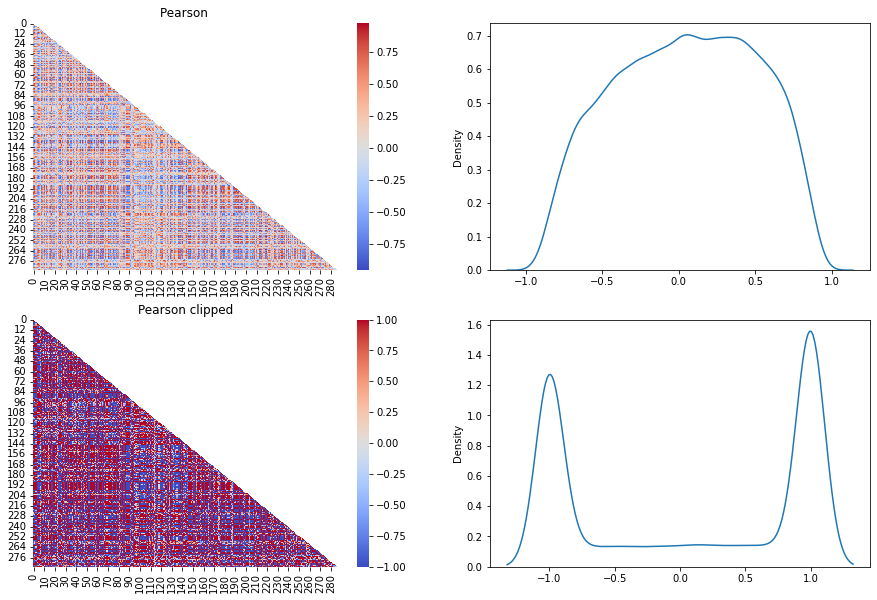

In [22]:
mat = pearson_matrix_refined
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(mat, ax=ax[0,0], cmap="coolwarm",mask = np.triu(mat))
sns.kdeplot(mat[np.triu_indices(mat.shape[0], 1)], ax = ax[0,1])
ax[0,0].set_title('Pearson ')

mat_clip = np.clip(mat/0.2,-1,1)
sns.heatmap(mat_clip, ax=ax[1,0], cmap="coolwarm",mask = np.triu(np.clip(mat_clip,-1,1)))
sns.kdeplot(mat_clip[np.triu_indices(mat_clip.shape[0], 1)], ax = ax[1,1])
ax[1,0].set_title('Pearson clipped')


Still some strong pearson correlations. Let's look at those series more closely

In [23]:
for i,j in list(zip(*np.where(np.abs(np.triu(pearson_matrix_refined,1))>0.95))):
    print(f'Pearson strong Pair: {esg_pivot_shifted_refined.columns[i]} {esg_pivot_shifted_refined.columns[j]}')

Pearson strong Pair: KMX CBOE
Pearson strong Pair: DG CBOE
Pearson strong Pair: MTD BAX
Pearson strong Pair: HUM CCI
Pearson strong Pair: IEX DOV
Pearson strong Pair: AMT CCI
Pearson strong Pair: ARE JNPR


[[1.         0.95750615]
 [0.95750615 1.        ]]


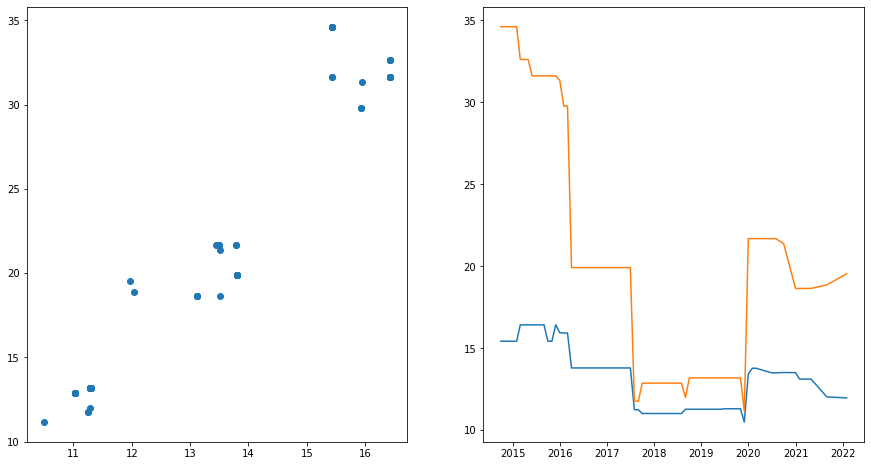

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
stock1 = 'KMX'
stock2 = 'CBOE'
x = np.array(esg_pivot_shifted_refined.index)
y1 = np.array(esg_pivot_shifted_refined[stock1])
y2 = np.array(esg_pivot_shifted_refined[stock2])


y1mask = np.isfinite(y1)
y2mask = np.isfinite(y2)
ymask = y1mask & y2mask
ax[0].scatter(y1[y1mask], y2[y2mask])
print(np.corrcoef(y1[y1mask],y2[y2mask]))

ax[1].plot(x[y1mask], y1[y1mask])
ax[1].plot(x[y1mask], y2[y2mask])





Extreme observations shifting correlations

# Kendall's tau b for non differenced series

We use the b variant which adjusts for ties

In [26]:
kendall_matrix = np.zeros((esg_pivot_shifted_refined.shape[1], esg_pivot_shifted_refined.shape[1]))

pbar = tqdm.tqdm(disable=False, total= (esg_pivot_shifted_refined.shape[1]-1)*esg_pivot_shifted_refined.shape[1]/2)
for i in range(esg_pivot_shifted_refined.shape[1]):
    for j in range(i, esg_pivot_shifted_refined.shape[1]):
        y1 = np.array(esg_pivot_shifted_refined.iloc[:,i])
        y2 = np.array(esg_pivot_shifted_refined.iloc[:,j])
        index = ~(np.isnan(y1) | np.isnan(y2))
        corr = scipy.stats.kendalltau(y1[index], y2[index])[0]
        # Sometimes there are no co-occuring observations
        if ~np.any(index):
            kendall_matrix[i,j] = 0
        # It can happen that there are only ~3 co-occuring observations. and one/both series are constant in that time frame
        elif np.isnan(corr) :
            kendall_matrix[i,j] = 0
        else:
            kendall_matrix[i,j] = corr
        pbar.update()
pbar.close()
kendall_matrix = np.triu(kendall_matrix) + np.triu(kendall_matrix, 1).T


41328it [00:35, 1148.67it/s]                             


Text(0.5, 1.0, 'Kendall clipped')

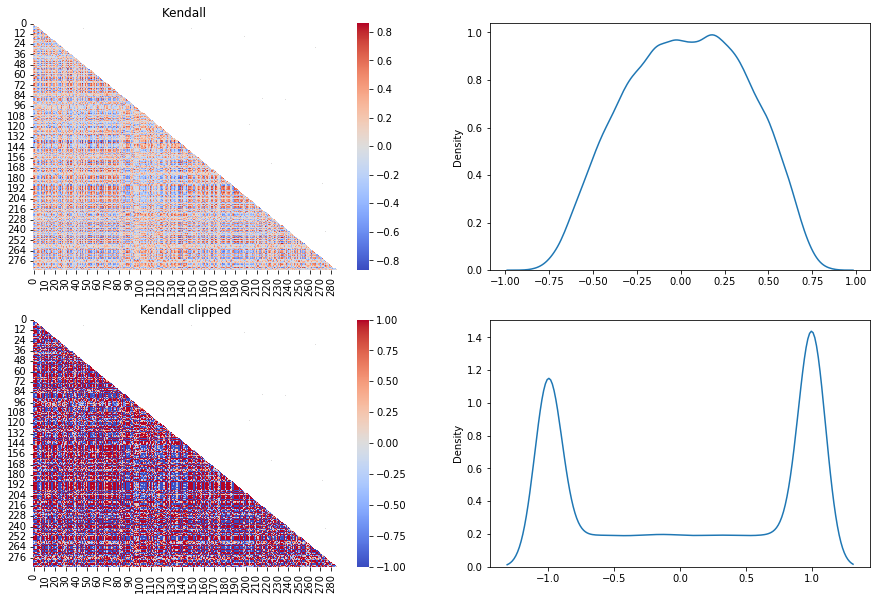

In [27]:
mat = kendall_matrix
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(mat, ax=ax[0,0], cmap="coolwarm",mask = np.triu(mat))
sns.kdeplot(mat[np.triu_indices(mat.shape[0], 1)], ax = ax[0,1])
ax[0,0].set_title('Kendall ')

mat_clip = np.clip(mat/0.2,-1,1)
sns.heatmap(mat_clip, ax=ax[1,0], cmap="coolwarm",mask = np.triu(np.clip(mat_clip,-1,1)))
sns.kdeplot(mat_clip[np.triu_indices(mat_clip.shape[0], 1)], ax = ax[1,1])
ax[1,0].set_title('Kendall clipped')


Again some strong correlations, but not as strong.

In [28]:
for i,j in list(zip(*np.where(np.abs(np.triu(kendall_matrix,1))>0.85))):
    print(f'Kendall strong Pair: {esg_pivot_shifted_refined.columns[i]} {esg_pivot_shifted_refined.columns[j]}')

Kendall strong Pair: BBY IVZ
Kendall strong Pair: MHK TAP
Kendall strong Pair: TAP CMA
Kendall strong Pair: MRK NDSN
Kendall strong Pair: FFIV ADI


Not the same pairs as for pearson. Let's look at kendells tau

[[ 1.        -0.9115165]
 [-0.9115165  1.       ]]


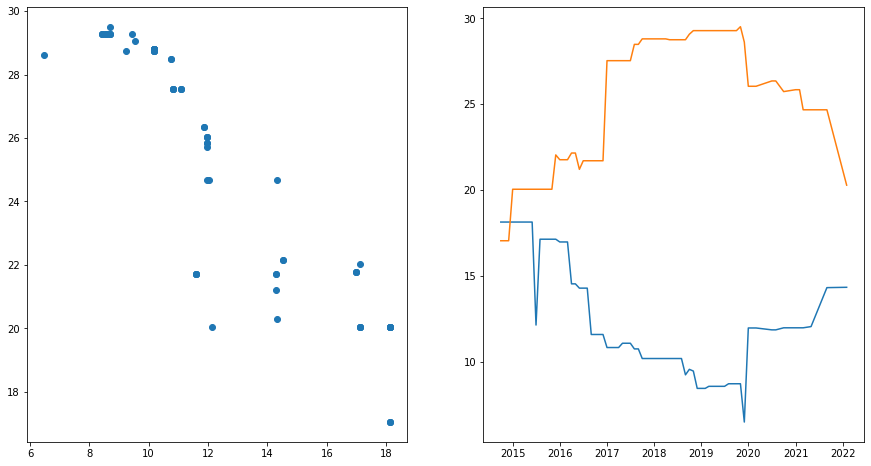

In [30]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
stock1 = 'BBY'
stock2 = 'IVZ'
x = np.array(esg_pivot_shifted_refined.index)
y1 = np.array(esg_pivot_shifted_refined[stock1])
y2 = np.array(esg_pivot_shifted_refined[stock2])


y1mask = np.isfinite(y1)
y2mask = np.isfinite(y2)
ymask = y1mask & y2mask
ax[0].scatter(y1[y1mask], y2[y2mask])
print(np.corrcoef(y1[y1mask],y2[y2mask]))

ax[1].plot(x[y1mask], y1[y1mask])
ax[1].plot(x[y1mask], y2[y2mask])

# Spearman's rank correlation for non differencd series

In [31]:
spearman_matrix = np.zeros((esg_pivot_shifted_refined.shape[1], esg_pivot_shifted_refined.shape[1]))

pbar = tqdm.tqdm(disable=False, total= (esg_pivot_shifted_refined.shape[1]-1)*esg_pivot_shifted_refined.shape[1]/2)
for i in range(esg_pivot_shifted_refined.shape[1]):
    for j in range(i, esg_pivot_shifted_refined.shape[1]):
        y1 = np.array(esg_pivot_shifted_refined.iloc[:,i])
        y2 = np.array(esg_pivot_shifted_refined.iloc[:,j])
        index = ~(np.isnan(y1) | np.isnan(y2))
        corr = scipy.stats.spearmanr(y1[index], y2[index])[0]
        # Sometimes there are no co-occuring observations
        if ~np.any(index):
            spearman_matrix[i,j] = 0
        # It can happen that there are only ~3 co-occuring observations. and one/both series are constant in that time frame
        elif np.isnan(corr) :
            spearman_matrix[i,j] = 0
        else:
            spearman_matrix[i,j] = corr
        pbar.update()
pbar.close()
spearman_matrix = np.triu(spearman_matrix) + np.triu(spearman_matrix, 1).T


41328it [00:59, 690.08it/s]                             


Text(0.5, 1.0, 'Spearman clipped')

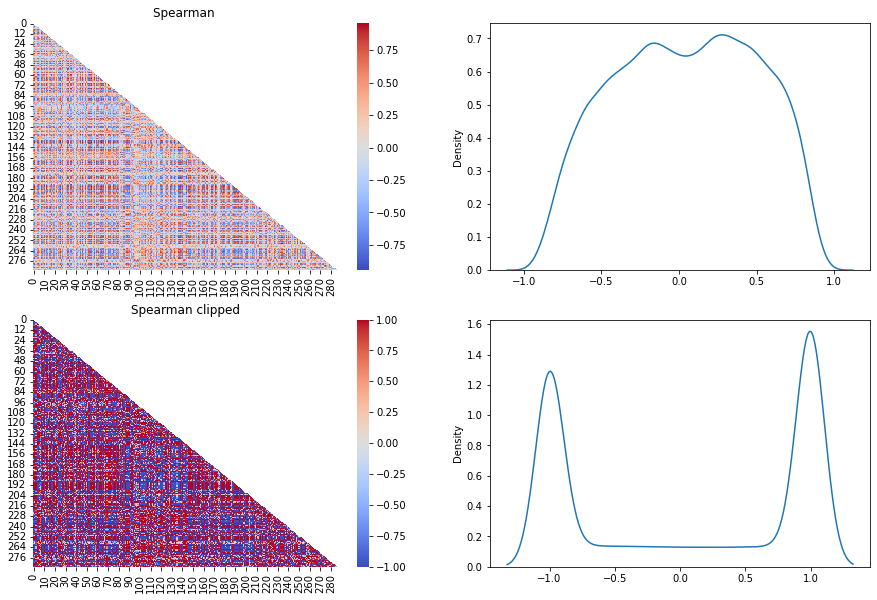

In [32]:
mat = spearman_matrix
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(mat, ax=ax[0,0], cmap="coolwarm",mask = np.triu(mat))
sns.kdeplot(mat[np.triu_indices(mat.shape[0], 1)], ax = ax[0,1])
ax[0,0].set_title('Spearman ')

mat_clip = np.clip(mat/0.2,-1,1)
sns.heatmap(mat_clip, ax=ax[1,0], cmap="coolwarm",mask = np.triu(np.clip(mat_clip,-1,1)))
sns.kdeplot(mat_clip[np.triu_indices(mat_clip.shape[0], 1)], ax = ax[1,1])
ax[1,0].set_title('Spearman clipped')


Again strong correlations like for the pearson. Are the pairs the same?

In [33]:
for i,j in list(zip(*np.where(np.abs(np.triu(spearman_matrix,1))>0.95))):
    print(f'Spearman strong Pair: {esg_pivot_shifted_refined.columns[i]} {esg_pivot_shifted_refined.columns[j]}')

Spearman strong Pair: BBY DG
Spearman strong Pair: MHK TAP
Spearman strong Pair: MHK CMA
Spearman strong Pair: MHK CTAS
Spearman strong Pair: TAP CMA
Spearman strong Pair: MRK NDSN
Spearman strong Pair: APH LRCX


In [34]:
for i,j in list(zip(*np.where(np.abs(np.triu(pearson_matrix_refined,1))>0.95))):
    print(f'Pearson strong Pair: {esg_pivot_shifted_refined.columns[i]} {esg_pivot_shifted_refined.columns[j]}')

Pearson strong Pair: KMX CBOE
Pearson strong Pair: DG CBOE
Pearson strong Pair: MTD BAX
Pearson strong Pair: HUM CCI
Pearson strong Pair: IEX DOV
Pearson strong Pair: AMT CCI
Pearson strong Pair: ARE JNPR


Not the same pairs though

[[1.         0.93332815]
 [0.93332815 1.        ]]


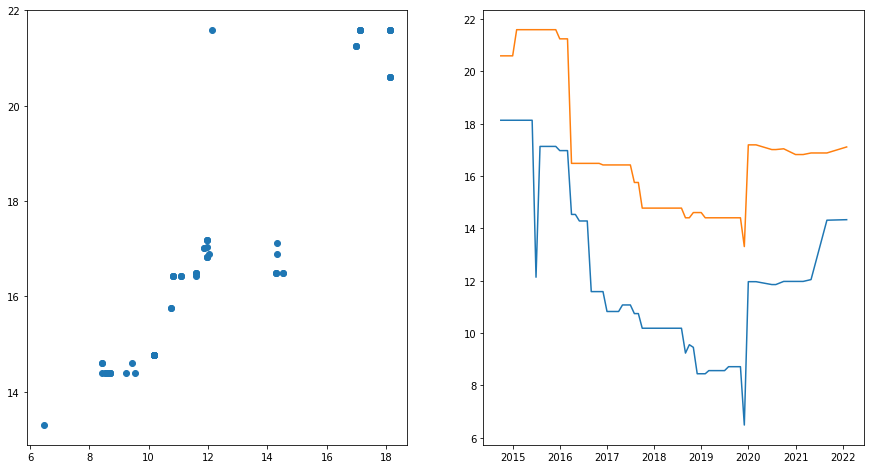

In [35]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
stock1 = 'BBY'
stock2 = 'DG'
x = np.array(esg_pivot_shifted_refined.index)
y1 = np.array(esg_pivot_shifted_refined[stock1])
y2 = np.array(esg_pivot_shifted_refined[stock2])


y1mask = np.isfinite(y1)
y2mask = np.isfinite(y2)
ymask = y1mask & y2mask
ax[0].scatter(y1[y1mask], y2[y2mask])
print(np.corrcoef(y1[y1mask],y2[y2mask]))

ax[1].plot(x[y1mask], y1[y1mask])
ax[1].plot(x[y1mask], y2[y2mask])

# Pearson for differenced series

Create a differenced series

In [36]:
esg_pivot_shifted_refined_diff = []
for i in range(esg_pivot_shifted_refined.shape[1]):
    diff = esg_pivot_shifted_refined.iloc[:,i].dropna().diff().iloc[1:]
    esg_pivot_shifted_refined_diff.append(diff)

esg_pivot_shifted_refined_diff = pd.merge(pd.DataFrame(index = esg_pivot_shifted_refined.index[esg_pivot_shifted_refined.index >= datetime.date(2014,11, 1)])
,pd.concat(esg_pivot_shifted_refined_diff, axis = 1), left_index = True, right_index = True, how = 'left')

In [37]:
pearson_matrix_diff = np.zeros((esg_pivot_shifted_refined_diff.shape[1], esg_pivot_shifted_refined_diff.shape[1]))

pbar = tqdm.tqdm(disable=False, total= (esg_pivot_shifted_refined_diff.shape[1]-1)*esg_pivot_shifted_refined_diff.shape[1]/2)
for i in range(esg_pivot_shifted_refined_diff.shape[1]):
    for j in range(i, esg_pivot_shifted_refined_diff.shape[1]):
        y1 = np.array(esg_pivot_shifted_refined_diff.iloc[:,i])
        y2 = np.array(esg_pivot_shifted_refined_diff.iloc[:,j])
        index = ~(np.isnan(y1) | np.isnan(y2))
        corr = np.corrcoef( y1[index], y2[index])[0,1]
        # Sometimes there are no co-occuring observations
        if ~np.any(index):
            pearson_matrix_diff[i,j] = 0
        # It can happen that there are only ~3 co-occuring observations. and one/both series are constant in that time frame
        elif np.isnan(corr) :
            pearson_matrix_diff[i,j] = 0
        else:
            pearson_matrix_diff[i,j] = corr
        pbar.update()
pbar.close()
pearson_matrix_diff = np.triu(pearson_matrix_diff) + np.triu(pearson_matrix_diff, 1).T


41328it [00:23, 1757.31it/s]                             


Text(0.5, 1.0, 'Pearson Differenced clipped')

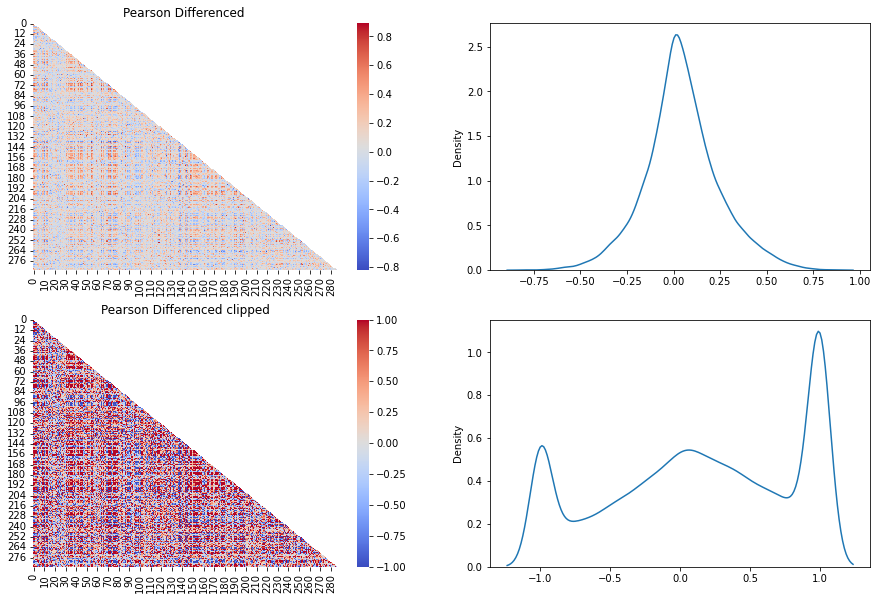

In [38]:
mat = pearson_matrix_diff
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(mat, ax=ax[0,0], cmap="coolwarm",mask = np.triu(mat))
sns.kdeplot(mat[np.triu_indices(mat.shape[0], 1)], ax = ax[0,1])
ax[0,0].set_title('Pearson Differenced ')

mat_clip = np.clip(mat/0.2,-1,1)
sns.heatmap(mat_clip, ax=ax[1,0], cmap="coolwarm",mask = np.triu(np.clip(mat_clip,-1,1)))
sns.kdeplot(mat_clip[np.triu_indices(mat_clip.shape[0], 1)], ax = ax[1,1])
ax[1,0].set_title('Pearson Differenced clipped')


We do not see as strong correlations as before

In [39]:
np.max(np.abs(np.triu(pearson_matrix_diff,1)))

0.8923028362282461

In [40]:
for i,j in list(zip(*np.where(np.abs(np.triu(pearson_matrix_diff,1))>0.85))):
    print(f'Pearson differened strong Pair: {esg_pivot_shifted_refined_diff.columns[i]} {esg_pivot_shifted_refined_diff.columns[j]}')

Pearson differened strong Pair: DG CBOE
Pearson differened strong Pair: MPC HOLX
Pearson differened strong Pair: MPC ISRG
Pearson differened strong Pair: RE LDOS
Pearson differened strong Pair: HOLX ISRG
Pearson differened strong Pair: CHRW CCI


In [42]:
for i,j in list(zip(*np.where(np.abs(np.triu(pearson_matrix_refined,1))>0.95))):
    print(f'Pearson strong Pair: {esg_pivot_shifted_refined.columns[i]} {esg_pivot_shifted_refined.columns[j]}')

Pearson strong Pair: KMX CBOE
Pearson strong Pair: DG CBOE
Pearson strong Pair: MTD BAX
Pearson strong Pair: HUM CCI
Pearson strong Pair: IEX DOV
Pearson strong Pair: AMT CCI
Pearson strong Pair: ARE JNPR


Also not same pairs as before

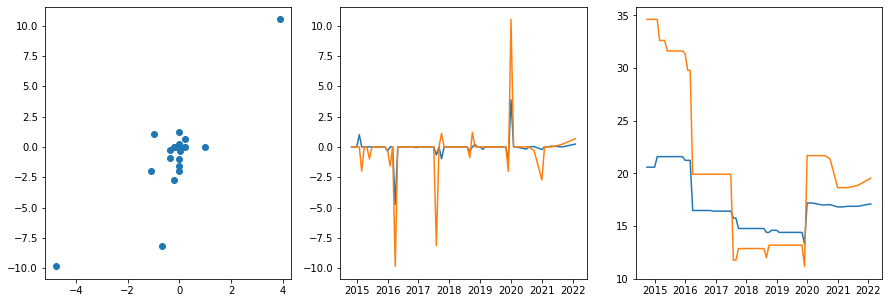

In [43]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
x = np.array(esg_pivot_shifted_refined_diff.index)
y1 = np.array(esg_pivot_shifted_refined_diff['DG'])
y2 = np.array(esg_pivot_shifted_refined_diff['CBOE'])

x_orig  =np.array(esg_pivot_shifted_refined.index)
y1_orig = np.array(esg_pivot_shifted_refined['DG'])
y2_orig = np.array(esg_pivot_shifted_refined['CBOE'])

y1mask = np.isfinite(y1)
y2mask = np.isfinite(y2)
ymask = y1mask & y2mask
ax[0].scatter(y1[y1mask], y2[y2mask])

ax[1].plot(x[y1mask], y1[y1mask])
ax[1].plot(x[y1mask], y2[y2mask])

y1mask = np.isfinite(y1_orig)
y2mask = np.isfinite(y2_orig)

ax[2].plot(x_orig[y1mask], y1_orig[y1mask])
ax[2].plot(x_orig[y1mask], y2_orig[y2mask])




Basically two extreme observations that create linear dependence

# Kendall for differenced series

In [44]:
kendall_matrix_diff = np.zeros((esg_pivot_shifted_refined_diff.shape[1], esg_pivot_shifted_refined_diff.shape[1]))

pbar = tqdm.tqdm(disable=False, total= (esg_pivot_shifted_refined_diff.shape[1]-1)*esg_pivot_shifted_refined_diff.shape[1]/2)
for i in range(esg_pivot_shifted_refined_diff.shape[1]):
    for j in range(i, esg_pivot_shifted_refined_diff.shape[1]):
        y1 = np.array(esg_pivot_shifted_refined_diff.iloc[:,i])
        y2 = np.array(esg_pivot_shifted_refined_diff.iloc[:,j])
        index = ~(np.isnan(y1) | np.isnan(y2))
        corr = scipy.stats.kendalltau( y1[index], y2[index])[0]
        # Sometimes there are no co-occuring observations
        if ~np.any(index):
            kendall_matrix_diff[i,j] = 0
        # It can happen that there are only ~3 co-occuring observations. and one/both series are constant in that time frame
        elif np.isnan(corr) :
            kendall_matrix_diff[i,j] = 0
        else:
            kendall_matrix_diff[i,j] = corr
        pbar.update()
pbar.close()
kendall_matrix_diff = np.triu(kendall_matrix_diff) + np.triu(kendall_matrix_diff, 1).T


41328it [00:48, 849.87it/s]                              


Text(0.5, 1.0, 'Kendall Differenced clipped')

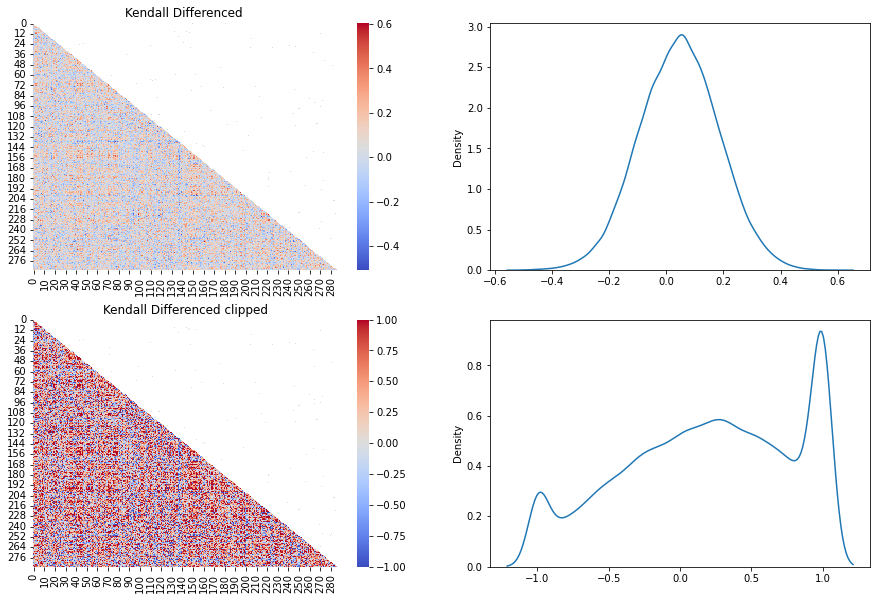

In [45]:
mat = kendall_matrix_diff
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(mat, ax=ax[0,0], cmap="coolwarm",mask = np.triu(mat))
sns.kdeplot(mat[np.triu_indices(mat.shape[0], 1)], ax = ax[0,1])
ax[0,0].set_title('Kendall Differenced ')

mat_clip = np.clip(mat/0.2,-1,1)
sns.heatmap(mat_clip, ax=ax[1,0], cmap="coolwarm",mask = np.triu(np.clip(mat_clip,-1,1)))
sns.kdeplot(mat_clip[np.triu_indices(mat_clip.shape[0], 1)], ax = ax[1,1])
ax[1,0].set_title('Kendall Differenced clipped')


In [82]:
np.max(np.abs(np.triu(kendall_matrix_diff,1)))

0.6038657617819329

In [239]:
for i,j in list(zip(*np.where(np.abs(np.triu(kendall_matrix_diff,1))>0.55))):
    print(f'Kendall differened strong Pair: {esg_pivot_shifted_refined_diff.columns[i]} {esg_pivot_shifted_refined_diff.columns[j]}')

for i,j in list(zip(*np.where(np.abs(np.triu(kendall_matrix,1))>0.85))):
    print(f'Kendall strong Pair: {esg_pivot_shifted_refined.columns[i]} {esg_pivot_shifted_refined.columns[j]}')
    

Kendall differened strong Pair: UAA JNPR
Kendall differened strong Pair: FDS EQR
Kendall differened strong Pair: BIO IPGP
Kendall differened strong Pair: FRT EQR
Kendall strong Pair: BBY IVZ
Kendall strong Pair: MHK TAP
Kendall strong Pair: TAP CMA
Kendall strong Pair: MRK NDSN
Kendall strong Pair: FFIV ADI


Again not the same pairs

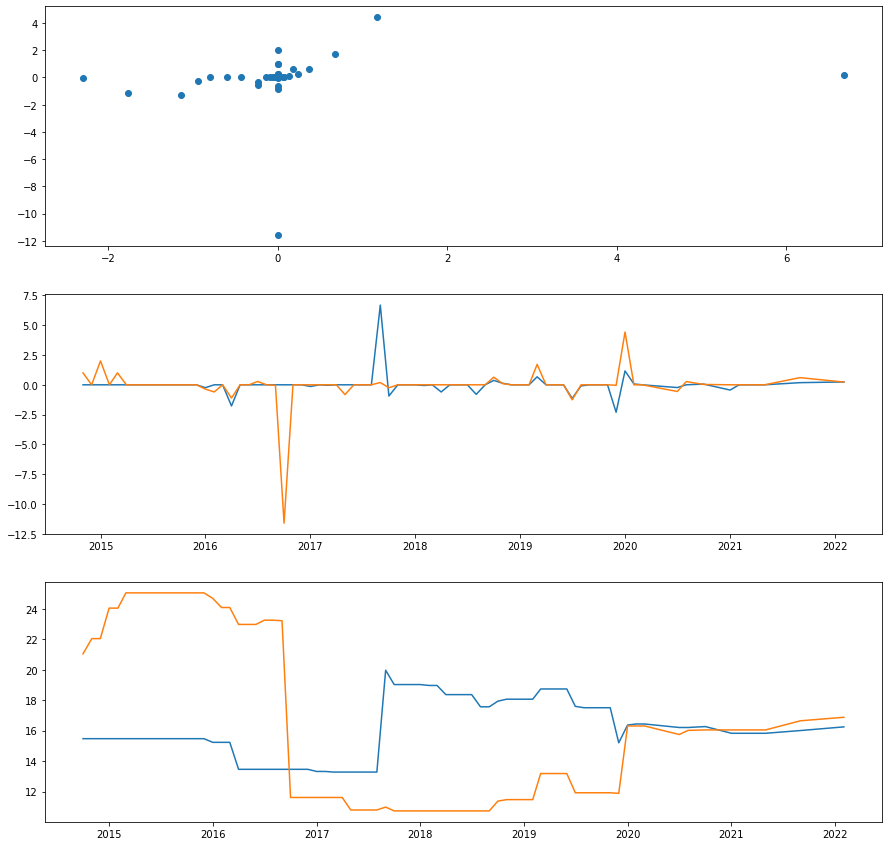

In [81]:
fig, ax = plt.subplots(3,1,figsize=(15,15))
stock1 = 'UAA'
stock2 = 'JNPR'
x = np.array(esg_pivot_shifted_refined_diff.index)
y1 = np.array(esg_pivot_shifted_refined_diff[stock1])
y2 = np.array(esg_pivot_shifted_refined_diff[stock2])

x_orig  =np.array(esg_pivot_shifted_refined.index)
y1_orig = np.array(esg_pivot_shifted_refined[stock1])
y2_orig = np.array(esg_pivot_shifted_refined[stock2])

y1mask = np.isfinite(y1)
y2mask = np.isfinite(y2)
ymask = y1mask & y2mask
ax[0].scatter(y1[y1mask], y2[y2mask])

ax[1].plot(x[y1mask], y1[y1mask])
ax[1].plot(x[y1mask], y2[y2mask])

y1mask = np.isfinite(y1_orig)
y2mask = np.isfinite(y2_orig)

ax[2].plot(x_orig[y1mask], y1_orig[y1mask])
ax[2].plot(x_orig[y1mask], y2_orig[y2mask])




# Spearman for differenced series

In [46]:
spearman_matrix_diff = np.zeros((esg_pivot_shifted_refined_diff.shape[1], esg_pivot_shifted_refined_diff.shape[1]))

pbar = tqdm.tqdm(disable=False, total= (esg_pivot_shifted_refined_diff.shape[1]-1)*esg_pivot_shifted_refined_diff.shape[1]/2)
for i in range(esg_pivot_shifted_refined_diff.shape[1]):
    for j in range(i, esg_pivot_shifted_refined_diff.shape[1]):
        y1 = np.array(esg_pivot_shifted_refined_diff.iloc[:,i])
        y2 = np.array(esg_pivot_shifted_refined_diff.iloc[:,j])
        index = ~(np.isnan(y1) | np.isnan(y2))
        corr = scipy.stats.spearmanr( y1[index], y2[index])[0]
        # Sometimes there are no co-occuring observations
        if ~np.any(index):
            spearman_matrix_diff[i,j] = 0
        # It can happen that there are only ~3 co-occuring observations. and one/both series are constant in that time frame
        elif np.isnan(corr) :
            spearman_matrix_diff[i,j] = 0
        else:
            spearman_matrix_diff[i,j] = corr
        pbar.update()
pbar.close()
spearman_matrix_diff = np.triu(spearman_matrix_diff) + np.triu(spearman_matrix_diff, 1).T


41328it [00:57, 724.40it/s]                              


Text(0.5, 1.0, 'Spearman for clipped differenced series')

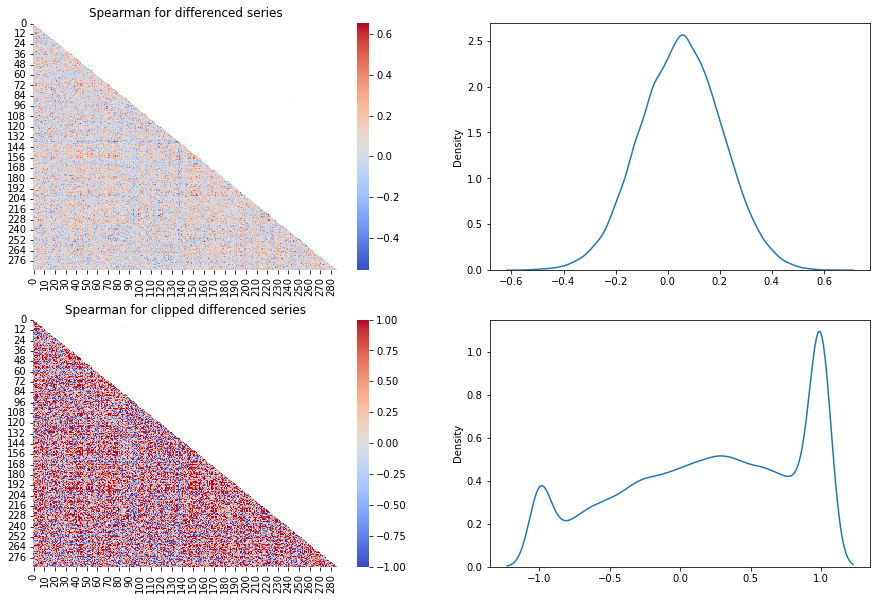

In [47]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(spearman_matrix_diff, ax=ax[0,0], cmap="coolwarm",mask = np.triu(spearman_matrix_diff))
sns.kdeplot(spearman_matrix_diff[np.triu_indices(spearman_matrix_diff.shape[0], 1)], ax = ax[0,1])
ax[0,0].set_title('Spearman for differenced series')

spearman_matrix_diff_cip = np.clip(spearman_matrix_diff/0.2,-1,1)
sns.heatmap(spearman_matrix_diff_cip, ax=ax[1,0], cmap="coolwarm",mask = np.triu(np.clip(spearman_matrix_diff_cip,-1,1)))
sns.kdeplot(spearman_matrix_diff_cip[np.triu_indices(spearman_matrix_diff_cip.shape[0], 1)], ax = ax[1,1])
ax[1,0].set_title('Spearman for clipped differenced series')

In [247]:
np.max(np.abs(np.triu(spearman_matrix_diff,1)))

0.6555405975145978

In [249]:
for i,j in list(zip(*np.where(np.abs(np.triu(spearman_matrix_diff,1))>0.6))):
    print(f'Kendall differened strong Pair: {esg_pivot_shifted_refined_diff.columns[i]} {esg_pivot_shifted_refined_diff.columns[j]}')

for i,j in list(zip(*np.where(np.abs(np.triu(spearman_matrix,1))>0.95))):
    print(f'Kendall strong Pair: {esg_pivot_shifted_refined.columns[i]} {esg_pivot_shifted_refined.columns[j]}')
    

Kendall differened strong Pair: UAA JNPR
Kendall differened strong Pair: FDS EQR
Kendall differened strong Pair: BIO IPGP
Kendall differened strong Pair: FRT EQR
Kendall strong Pair: BBY DG
Kendall strong Pair: MHK TAP
Kendall strong Pair: MHK CMA
Kendall strong Pair: MHK CTAS
Kendall strong Pair: TAP CMA
Kendall strong Pair: MRK NDSN
Kendall strong Pair: APH LRCX


These are the same pairs as for kendall's tau for the differenced series!